### Price prediction and classification notebook
This notebook loads data and prepares  for price prediction workflow.

In [28]:
import pandas as pd
import numpy as py

from google.colab import drive
drive.mount('/content/drive')

# Load CSV file from Google Drive
file_path = '/content/drive/MyDrive/fourth/project/wfp_food_prices_eth.csv'
df = pd.read_csv(file_path)

# Access a column
print(df.shape)
print(df.columns)

# View first 5 rows
print(df.head(8))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(40482, 14)
Index(['date', 'admin1', 'admin2', 'market', 'latitude', 'longitude',
       'category', 'commodity', 'unit', 'priceflag', 'pricetype', 'currency',
       'price', 'usdprice'],
      dtype='object')
         date       admin1                             admin2  \
0       #date   #adm1+name                         #adm2+name   
1  2000-01-15  Addis Ababa                           AA ZONE1   
2  2000-01-15  Addis Ababa                           AA ZONE1   
3  2000-01-15  Addis Ababa                           AA ZONE1   
4  2000-01-15  Addis Ababa                           AA ZONE1   
5  2000-01-15       Amhara  Administrative unit not available   
6  2000-01-15    Dire Dawa                          DIRE DAWA   
7  2000-01-15       Tigray                             MEKELE   

             market   latitude  longitude            category  \
0  #loc+m

In [29]:
import pandas as pd
import numpy as np

# Drop first row, reset index, convert date column to datetime, and cast numeric columns
df = (
    df.drop(0)
      .reset_index(drop=True)
      .assign(date=lambda x: pd.to_datetime(x['date']))
      .astype({'price': float, 'usdprice': float})
)

# Sort by date, drop duplicates, reset index
df = df.sort_values('date').drop_duplicates().reset_index(drop=True)

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Clean commodity column: remove parentheses text and extract variety
df['commodity_base'] = df['commodity'].str.replace(r'\s*\(.*?\)', '', regex=True).str.strip()
df['variety'] = df['commodity'].str.extract(r'\((.*?)\)', expand=False).fillna('')

# Check missing values
print(df.isnull().sum())

# Replace unavailable admin2 values with NaN
df['admin2'] = df['admin2'].replace('Administrative unit not available', np.nan)

# Convert latitude and longitude to numeric
df[['latitude', 'longitude']] = df[['latitude', 'longitude']].apply(pd.to_numeric, errors='coerce')

# Keep only rows with positive price
df = df[df['price'] > 0].reset_index(drop=True)

# Convert categorical columns
df[['admin1', 'admin2', 'market', 'pricetype', 'category']] = df[['admin1', 'admin2', 'market', 'pricetype', 'category']].astype('category')

# Handle missing admin2 values
df['admin2'] = df['admin2'].cat.add_categories('Unknown').fillna('Unknown')

# Drop rows with missing admin1, latitude, longitude
df = df.dropna(subset=['admin1', 'latitude', 'longitude']).reset_index(drop=True)

# Replace empty variety with 'Standard'
df['variety'] = df['variety'].replace('', 'Standard').fillna('Standard')

# Clean unit column
df['unit'] = df['unit'].str.strip().str.upper()

# Drop unnecessary columns
df = df.drop(columns=['commodity','priceflag','currency'])

# Final checks
print(df.shape)
print(df.tail())
print(df.head())

date              0
admin1            5
admin2            5
market            0
latitude          5
longitude         5
category          0
commodity         0
unit              0
priceflag         0
pricetype         0
currency          0
price             0
usdprice          0
year              0
month             0
commodity_base    0
variety           0
dtype: int64
(40476, 15)
            date   admin1  admin2             market  latitude  longitude  \
40471 2023-12-15  Gambela  ZONE 3  Kowerneng/Korgang  8.326659  33.953408   
40472 2023-12-15  Gambela  ZONE 2             Punido  7.749505  34.426848   
40473 2023-12-15  Gambela  ZONE 2             Punido  7.749505  34.426848   
40474 2023-12-15  Gambela  ZONE 2             Punido  7.749505  34.426848   
40475 2023-12-15   Somali    GODE               Gode  6.022500  43.130278   

                  category    unit pricetype    price  usdprice  year  month  \
40471   cereals and tubers  100 KG    Retail   4500.0   80.7609  2023   

Outliers detected: 297


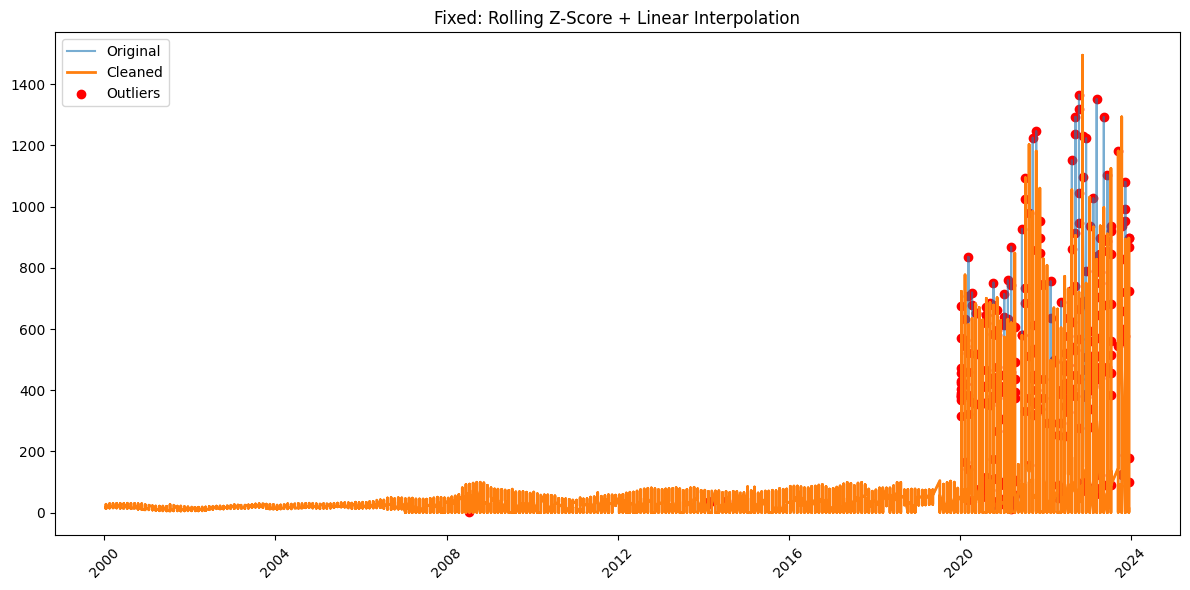

In [31]:
# ============================================================
# FIXED: Rolling Z-Score + Linear Interpolation (NO NaNs, NO outliers)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = df.sort_values('date').reset_index(drop=True)

window = 12
z_threshold = 3

# Rolling stats (min_periods=1 to reduce NaNs)
df['rolling_mean'] = df['usdprice'].rolling(window, min_periods=1).mean()
df['rolling_std']  = df['usdprice'].rolling(window, min_periods=2).std()

df['z_score'] = (df['usdprice'] - df['rolling_mean']) / df['rolling_std']
df['z_score'] = df['z_score'].fillna(0)          # safe for first row

# Detect
df['is_outlier'] = df['z_score'].abs() > z_threshold
print("Outliers detected:", df['is_outlier'].sum())

# FIX: Linear interpolation (recommended)
df['usdprice_cleaned'] = df['usdprice'].mask(df['is_outlier'], np.nan)
df['usdprice_cleaned'] = df['usdprice_cleaned'].interpolate(method='linear')

# Optional: drop helper columns later if not needed as features
# df = df.drop(['rolling_mean','rolling_std','z_score','is_outlier'], axis=1)

# Visualize
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['usdprice'], label='Original', alpha=0.6)
plt.plot(df['date'], df['usdprice_cleaned'], label='Cleaned', linewidth=2)
plt.scatter(df.loc[df['is_outlier'], 'date'], df.loc[df['is_outlier'], 'usdprice'], color='red', label='Outliers')
plt.legend()
plt.title("Fixed: Rolling Z-Score + Linear Interpolation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40476 entries, 0 to 40475
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              40476 non-null  datetime64[ns]
 1   admin1            40476 non-null  category      
 2   admin2            40476 non-null  category      
 3   market            40476 non-null  category      
 4   latitude          40476 non-null  float64       
 5   longitude         40476 non-null  float64       
 6   category          40476 non-null  category      
 7   unit              40476 non-null  object        
 8   pricetype         40476 non-null  category      
 9   price             40476 non-null  float64       
 10  usdprice          40476 non-null  float64       
 11  year              40476 non-null  int32         
 12  month             40476 non-null  int32         
 13  commodity_base    40476 non-null  object        
 14  variety           4047

In [32]:
encoding_cols = [
    'admin1','admin2','market',
    'category','pricetype',
    'unit','commodity_base','variety'
]

# Show unique counts and sample categories
for col in encoding_cols:
    print(f"\nColumn: {col}")
    print(f"Unique count: {df[col].nunique()}")
    print(f"Categories: {df[col].unique()[:10]}")  # show first 10 unique values


Column: admin1
Unique count: 11
Categories: ['Addis Ababa', 'Amhara', 'Dire Dawa', 'Tigray', 'Oromia', 'SNNPR', 'Somali', 'Afar', 'Gambela', 'B. Gumuz']
Categories (11, object): ['Addis Ababa', 'Afar', 'Amhara', 'B. Gumuz', ..., 'Oromia', 'SNNPR', 'Somali',
                          'Tigray']

Column: admin2
Unique count: 59
Categories: ['AA ZONE1', 'Unknown', 'DIRE DAWA', 'MEKELE', 'WEST SHEWA', 'E. SHEWA', 'BALE', 'HADIYA', 'JIMMA', 'N. GONDER']
Categories (59, object): ['AA ZONE1', 'AFDER', 'ALABA SW', 'AMARO SW', ..., 'ZONE3', 'ZONE4', 'ZONE5',
                          'Unknown']

Column: market
Unique count: 118
Categories: ['Addis Ababa', 'Baher Dar', 'Diredawa', 'Mekele', 'Ambo', 'Nazareth', 'Robe', 'Shashemene', 'Hossana', 'Jimma']
Categories (119, object): ['Abaala', 'Abi Adi', 'Abomsa', 'Addis Ababa', ..., 'Wonago', 'Wukro',
                           'Yabelo', 'Ziway']

Column: category
Unique count: 8
Categories: ['cereals and tubers', 'pulses and nuts', 'miscellaneous fo

In [ ]:
print(df.columns)
print(df.info())
df.describe()

Index(['date', 'admin1', 'admin2', 'market', 'latitude', 'longitude',
       'category', 'unit', 'pricetype', 'price', 'usdprice', 'year', 'month',
       'commodity_base', 'variety', 'rolling_mean', 'rolling_std', 'z_score',
       'is_outlier', 'usdprice_cleaned'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40476 entries, 0 to 40475
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              40476 non-null  datetime64[ns]
 1   admin1            40476 non-null  category      
 2   admin2            40476 non-null  category      
 3   market            40476 non-null  category      
 4   latitude          40476 non-null  float64       
 5   longitude         40476 non-null  float64       
 6   category          40476 non-null  category      
 7   unit              40476 non-null  object        
 8   pricetype         40476 non-null  category      
 9   pr

,date,latitude,longitude,price,usdprice,year,month,rolling_mean,rolling_std,z_score,usdprice_cleaned
count,40476,40476.000000,40476.000000,40476.000000,40476.000000,40476.000000,40476.000000,40476.000000,40475.000000,40476.000000,40476.000000
mean,2018-09-22 21:15:27.482952960,9.490376,39.626584,2533.982040,59.247781,2018.244688,6.333185,59.242446,64.267044,0.003422,56.439036
min,2000-01-15 00:00:00,3.534996,33.953408,0.880000,0.091600,2000.000000,1.000000,0.443800,0.083253,-2.979544,0.091600
25%,2015-01-15 00:00:00,7.666667,38.420666,94.000000,2.071175,2015.000000,3.000000,25.988827,21.189784,-0.687780,2.030900
50%,2020-11-15 00:00:00,9.313870,39.544560,800.000000,37.239250,2020.000000,6.000000,53.985992,38.338827,-0.207162,36.987500
75%,2022-06-15 00:00:00,11.340700,41.416665,3400.000000,74.992500,2022.000000,9.000000,81.557225,93.623168,0.598329,74.225050
max,2023-12-15 00:00:00,14.454050,44.279701,79000.000000,1495.079500,2023.000000,12.000000,361.263567,494.504329,3.175412,1495.079500
std,NaN,2.502090,1.956364,4729.544242,94.791431,5.153325,3.467811,39.842810,62.771811,0.981759,84.531279


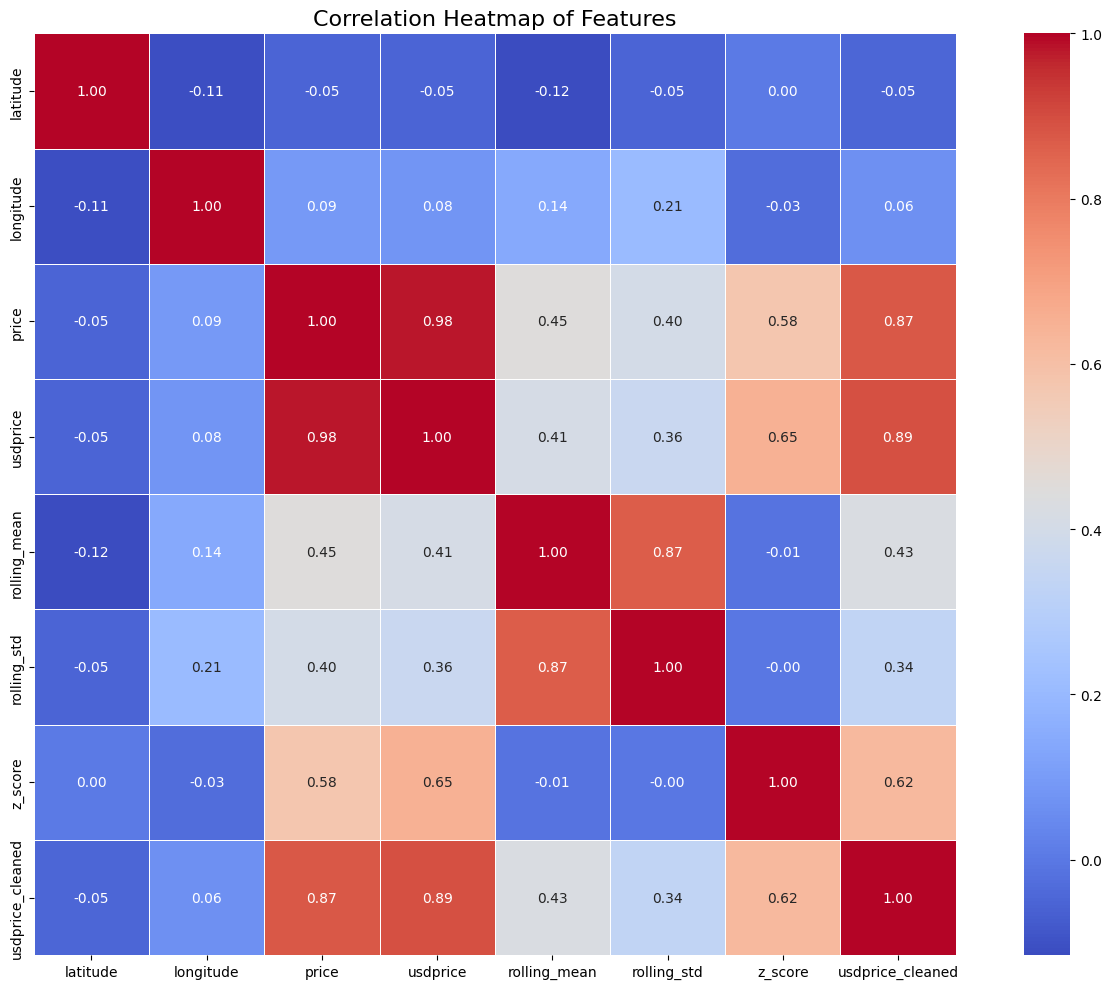

In [33]:

# ============================================================
# CORRELATION HEATMAP
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Use only numeric columns for correlation
numeric_df = df.select_dtypes(include=['int64','float64'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(14,10))

# Draw the heatmap with annotations
sns.heatmap(
    corr_matrix,
    annot=True,        # show correlation values
    fmt=".2f",         # 2 decimal points
    cmap='coolwarm',   # color map
    cbar=True,
    square=True,
    linewidths=0.5
)

plt.title("Correlation Heatmap of Features", fontsize=16)
plt.tight_layout()
plt.show()

In [34]:
# inplace
df.drop(['is_outlier','rolling_std'], axis=1, inplace=True)

✅ Preprocessing Complete
Shape: (40476, 24)

Data Types:
 date                              datetime64[ns]
admin1                                  category
admin2                                  category
market                                     int64
latitude                                 float64
longitude                                float64
unit                                       int64
pricetype                                  int64
price                                    float64
usdprice                                 float64
year                                       int32
month                                      int32
commodity_base                             int64
variety                                    int64
rolling_mean                             float64
z_score                                  float64
usdprice_cleaned                         float64
category_meat, fish and eggs                bool
category_milk and dairy                     bool
category_mi

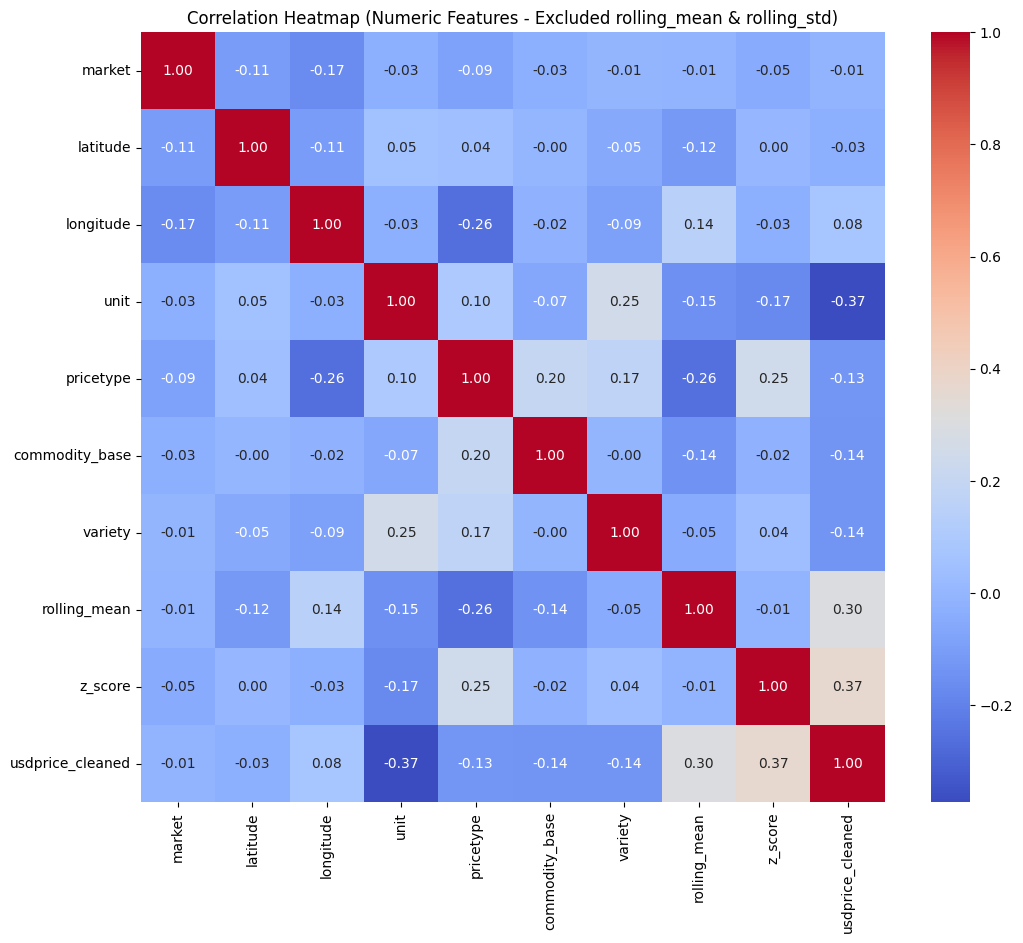

In [35]:
# ============================================================
# FULL DATA PREPROCESSING PIPELINE (ML READY)
# ============================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ CLEAN & STANDARDIZE UNITS
# -----------------------------
df['unit'] = df['unit'].astype(str).str.strip().str.upper()

# Convert bulk to per KG (optional but recommended)
df.loc[df['unit']=='100 KG','usdprice_cleaned'] /= 100
df['unit'] = df['unit'].replace('100 KG','KG')

# -----------------------------
# 2️⃣ CLEAN & FIX PRICETYPE
# -----------------------------
df['pricetype'] = df['pricetype'].astype(str).str.strip().str.lower()

# Map to numeric safely using map (avoids FutureWarning)
pricetype_map = {'retail': 0, 'wholesale': 1, '0': 0, '1': 1}
df['pricetype'] = df['pricetype'].map(pricetype_map)

# Fill any remaining NaNs with mode
df['pricetype'] = df['pricetype'].fillna(df['pricetype'].mode()[0]).astype(int)

# -----------------------------
# 3️⃣ CLEAN & CONVERT OTHER CATEGORICALS
# -----------------------------
cat_cols = ['admin1','admin2','market','category']
for col in cat_cols:
    df[col] = df[col].astype(str).str.strip().replace('', 'Unknown').astype('category')

# -----------------------------
# 4️⃣ ONE-HOT ENCODING (LOW CARDINALITY)
# -----------------------------
if 'category' in df.columns:
    df = pd.get_dummies(df, columns=['category'], drop_first=True)

# -----------------------------
# 5️⃣ LABEL ENCODING (HIGH CARDINALITY)
# -----------------------------
label_cols = ['market','unit','commodity_base','variety']
encoders = {}
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# -----------------------------
# 6️⃣ FINAL CHECK
# -----------------------------
print("✅ Preprocessing Complete")
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nSample Data:")
print(df.head())

# -----------------------------
# 7️⃣ CORRELATION HEATMAP (exclude 2 columns)
# -----------------------------

exclude_cols = ['price', 'usdprice']  # ← change these

numeric_df = df.select_dtypes(include=['int64','float64'])
numeric_df = numeric_df.drop(columns=exclude_cols, errors='ignore')

plt.figure(figsize=(12,10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features - Excluded rolling_mean & rolling_std)")
plt.show()

Training samples: 26969
Testing samples: 13507

Linear Regression
MAE : 35.04
RMSE: 73.23
R²  : 0.466

Random Forest
MAE : 6.13
RMSE: 22.64
R²  : 0.949

Gradient Boosting
MAE : 8.6
RMSE: 25.39
R²  : 0.936

Extra Trees
MAE : 6.79
RMSE: 26.17
R²  : 0.932

MODEL COMPARISON
               Model        MAE       RMSE        R2
1      Random Forest   6.127835  22.636581  0.948936
2  Gradient Boosting   8.597800  25.391629  0.935749
3        Extra Trees   6.789887  26.165024  0.931776
0  Linear Regression  35.041264  73.233905  0.465533


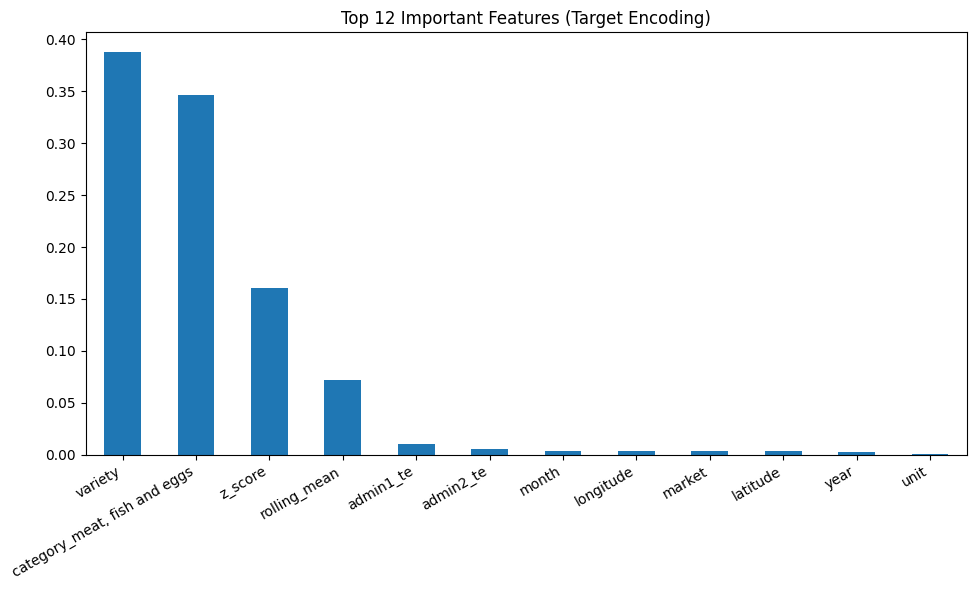

In [36]:
# ============================================================
# MULTI-MODEL PIPELINE WITH K-FOLD TARGET ENCODING
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor

# ------------------------------------------------------------
# 1️⃣ TIME-BASED SPLIT
# ------------------------------------------------------------
train = df[df['year'] <= 2021].copy()
test = df[df['year'] > 2021].copy()

# ------------------------------------------------------------
# 2️⃣ K-FOLD TARGET ENCODING FUNCTION
# ------------------------------------------------------------
def kfold_target_encoding(train_df, test_df, column, target, n_splits=5):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    train_encoded = pd.Series(index=train_df.index, dtype=float)

    global_mean = train_df[target].mean()

    for train_idx, val_idx in kf.split(train_df):

        fold_train = train_df.iloc[train_idx]
        fold_val = train_df.iloc[val_idx]

        # Add observed=False to groupby to address FutureWarning and ensure all categories are considered
        means = fold_train.groupby(column, observed=False)[target].mean()

        # Explicitly cast to float to prevent potential internal type issues during assignment
        train_encoded.iloc[val_idx] = fold_val[column].map(means).astype(float)

    train_encoded.fillna(global_mean, inplace=True)

    # Encode test using full training data
    full_means = train_df.groupby(column, observed=False)[target].mean() # Add observed=False here too
    test_encoded = test_df[column].map(full_means).astype(float)
    test_encoded.fillna(global_mean, inplace=True)

    return train_encoded, test_encoded

# ------------------------------------------------------------
# 3️⃣ APPLY TARGET ENCODING TO admin1 & admin2
# ------------------------------------------------------------
for col in ['admin1', 'admin2']:
    train[col + '_te'], test[col + '_te'] = kfold_target_encoding(
        train, test, column=col, target='usdprice_cleaned'
    )

# Drop original categorical columns
train.drop(columns=['admin1','admin2'], inplace=True)
test.drop(columns=['admin1','admin2'], inplace=True)

# ------------------------------------------------------------
# 4️⃣ DEFINE FEATURES & TARGET
# ------------------------------------------------------------
X_train = train.drop(columns=['usdprice_cleaned','date','usdprice','price'])
y_train = train['usdprice_cleaned']

X_test = test.drop(columns=['usdprice_cleaned','date','usdprice','price'])
y_test = test['usdprice_cleaned']

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

# ------------------------------------------------------------
# 5️⃣ INITIALIZE MODELS
# ------------------------------------------------------------
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Extra Trees": ExtraTreesRegressor(n_estimators=120, random_state=42, n_jobs=-1)
}

results = []

# ------------------------------------------------------------
# 6️⃣ TRAIN & EVALUATE
# ------------------------------------------------------------
for name, model in models.items():

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results.append([name, mae, rmse, r2])

    print(f"\n{name}")
    print("MAE :", round(mae,2))
    print("RMSE:", round(rmse,2))
    print("R²  :", round(r2,3))

# ------------------------------------------------------------
# 7️⃣ RESULTS TABLE
# ------------------------------------------------------------
results_df = pd.DataFrame(results, columns=['Model','MAE','RMSE','R2'])
print("\nMODEL COMPARISON")
print(results_df.sort_values('R2', ascending=False))

# ------------------------------------------------------------
# 8️⃣ FEATURE IMPORTANCE (BEST TREE MODEL)
# ------------------------------------------------------------
best_model = RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1)
best_model.fit(X_train, y_train)

importance = pd.Series(best_model.feature_importances_, index=X_train.columns)
importance = importance.sort_values(ascending=False)

plt.figure(figsize=(10,6))
importance.head(12).plot(kind='bar')

plt.title("Top 12 Important Features (Target Encoding)")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


========== EARLY WARNING DISTRIBUTION BY REGION ==========
early_warning_level  Low Risk  Moderate Risk  Severe Risk
admin1                                                   
Addis Ababa              1717             71          160
Afar                      792             65          112
Amhara                   4293           3761          908
B. Gumuz                  472              0            1
Dire Dawa                1513             87          175
Gambela                  1034             13            3
Harari                    648             34            2
Oromia                  11032            321          588
SNNPR                    3027             35           80
Somali                    861           2786         1257
Tigray                   2944            922          762


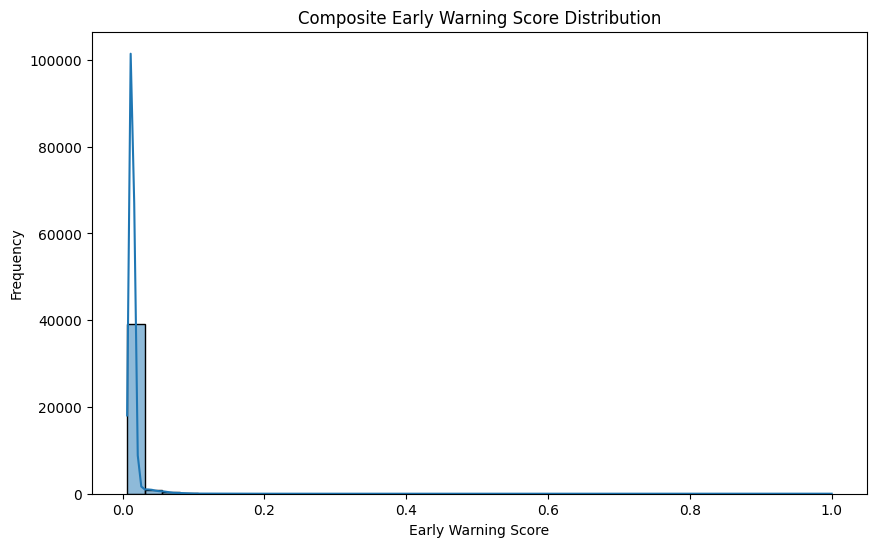


Top High-Risk Foods:
 commodity_base
24    7225
49    5873
23    4880
41    4720
46    2590
3     1885
30    1202
48    1105
35     917
34     813
Name: count, dtype: int64

Top High-Risk Regions:
 admin1       admin2   
Somali       JIJIGA       488
Tigray       MEKELE       344
Somali       LIBEN        315
             GODE         301
Dire Dawa    DIRE DAWA    175
Tigray       C. TIGRAY    168
Oromia       E. SHEWA     166
Amhara       S. WELLO     161
Addis Ababa  AA ZONE1     160
Amhara       N. GONDER    149
dtype: int64


In [37]:
# ===============================================================
# FOOD CRISIS EARLY WARNING SYSTEM (One-Class / Event-Based)
# Updated to fix pandas FutureWarnings
# ===============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

# =========================
# 1️⃣ Rolling Z-Score Event Definition
# =========================
df = df.sort_values(['commodity_base','date']).copy()

df['price_rolling_mean'] = df.groupby('commodity_base')['price'].transform(
    lambda x: x.rolling(6, min_periods=1).mean()
)
df['price_rolling_std'] = df.groupby('commodity_base')['price'].transform(
    lambda x: x.rolling(6, min_periods=1).std()
)

df['price_zscore'] = (df['price'] - df['price_rolling_mean']) / (df['price_rolling_std'] + 1e-9)
df['high_risk_event'] = (df['price_zscore'] > 2).astype(int)

# =========================
# 2️⃣ Time-Based Split
# =========================
train = df[df['year'] <= 2021].copy()
test  = df[df['year'] > 2021].copy()

# =========================
# 3️⃣ Target Encoding for admin1 & admin2
# =========================
def target_encode(train_df, test_df, col, target):
    means = train_df.groupby(col, observed=True)[target].mean()  # fixed
    overall_mean = train_df[target].mean()

    train_enc = train_df[col].map(means).astype(float).fillna(overall_mean)
    test_enc  = test_df[col].map(means).astype(float).fillna(overall_mean)
    return train_enc, test_enc

train['admin1_enc'], test['admin1_enc'] = target_encode(train, test, 'admin1', 'high_risk_event')
train['admin2_enc'], test['admin2_enc'] = target_encode(train, test, 'admin2', 'high_risk_event')

train.drop(columns=['admin1','admin2'], inplace=True)
test.drop(columns=['admin1','admin2'], inplace=True)

# =========================
# 4️⃣ Define Features & Target
# =========================
exclude_cols = ['usdprice','price','date','high_risk_event','price_rolling_mean','price_rolling_std','price_zscore']
if 'early_warning_level' in df.columns:
    exclude_cols.append('early_warning_level')

X_train = train.drop(columns=exclude_cols, errors='ignore')
y_train = train['high_risk_event']

X_test = test.drop(columns=exclude_cols, errors='ignore')
y_test = test['high_risk_event']

# =========================
# 5️⃣ Preprocessing (Scaling)
# =========================
num_cols = ['latitude','longitude','year','month','unit','pricetype','commodity_base','variety','admin1_enc','admin2_enc']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# =========================
# 6️⃣ Train ML Model (Extra Trees)
# =========================
ml_model = ExtraTreesClassifier(n_estimators=200, max_depth=15, random_state=42, class_weight='balanced')
ml_model.fit(X_train, y_train)

# =========================
# 7️⃣ Predict Event Probabilities
# =========================
df_ml = pd.concat([X_train, X_test], axis=0)
df['ml_probability'] = ml_model.predict_proba(df_ml)[:,1]
df['ml_norm'] = (df['ml_probability'] - df['ml_probability'].min()) / \
                (df['ml_probability'].max() - df['ml_probability'].min() + 1e-9)

# =========================
# 8️⃣ Structural & Shock Risk
# =========================
# Structural Risk → Inequality Index
region_avg = df.groupby(['admin1','commodity_base'], observed=True)['price'].mean().reset_index()  # fixed
national_avg = df.groupby('commodity_base', observed=True)['price'].mean().reset_index().rename(columns={'price':'national_avg'})
region_avg = region_avg.merge(national_avg, on='commodity_base')
region_avg['price_ratio'] = region_avg['price'] / region_avg['national_avg']

volatility = df.groupby('admin1', observed=True)['price'].agg(['mean','std']).reset_index()  # fixed
volatility['cv'] = volatility['std'] / volatility['mean']

inequality = region_avg.merge(volatility[['admin1','cv']], on='admin1')
inequality['ratio_norm'] = (inequality['price_ratio'] - inequality['price_ratio'].min()) / (inequality['price_ratio'].max() - inequality['price_ratio'].min() + 1e-9)
inequality['cv_norm'] = (inequality['cv'] - inequality['cv'].min()) / (inequality['cv'].max() - inequality['cv'].min() + 1e-9)
inequality['inequality_index'] = 0.6*inequality['ratio_norm'] + 0.4*inequality['cv_norm']

df = df.merge(inequality[['admin1','commodity_base','inequality_index']], on=['admin1','commodity_base'], how='left')
df['inequality_index'] = df['inequality_index'].fillna(df['inequality_index'].mean())

# Shock Risk → Inflation Shock Index
df = df.sort_values(['commodity_base','date'])
df['inflation'] = df.groupby('commodity_base')['price'].pct_change()*100
df['infl_vol'] = df.groupby('commodity_base')['inflation'].rolling(3, min_periods=1).std().reset_index(0,drop=True)
df['infl_norm'] = (df['inflation'] - df['inflation'].min()) / (df['inflation'].max() - df['inflation'].min() + 1e-9)
df['infl_vol_norm'] = (df['infl_vol'] - df['infl_vol'].min()) / (df['infl_vol'].max() - df['infl_vol'].min() + 1e-9)
df['inflation_shock_index'] = 0.7*df['infl_norm'].fillna(0) + 0.3*df['infl_vol_norm'].fillna(0)

# =========================
# 9️⃣ Composite Early Warning Score
# =========================
ew_features = ['inequality_index','inflation_shock_index','ml_norm']
lr = LogisticRegression(max_iter=500)
lr.fit(df[ew_features], df['high_risk_event'])

df['early_warning_score'] = lr.predict_proba(df[ew_features])[:,1]

df['early_warning_level'] = pd.qcut(df['early_warning_score'], q=[0,0.7,0.9,1],
                                    labels=['Low Risk','Moderate Risk','Severe Risk'])

# =========================
# 1️⃣0️⃣ Summary Outputs
# =========================
summary = df.groupby(['admin1','early_warning_level'], observed=True).size().unstack(fill_value=0)  # fixed
print("\n========== EARLY WARNING DISTRIBUTION BY REGION ==========")
print(summary)

plt.figure(figsize=(10,6))
sns.histplot(df['early_warning_score'], bins=40, kde=True)
plt.title("Composite Early Warning Score Distribution")
plt.xlabel("Early Warning Score")
plt.ylabel("Frequency")
plt.show()

# Top high-risk foods
high_risk_foods = df.sort_values('early_warning_score', ascending=False)['commodity_base'].value_counts().head(10)
print("\nTop High-Risk Foods:\n", high_risk_foods)

# Top high-risk regions
high_risk_regions = df[df['early_warning_level']=='Severe Risk'] \
    .groupby(['admin1','admin2'], observed=True).size().sort_values(ascending=False).head(10)  # fixed
print("\nTop High-Risk Regions:\n", high_risk_regions)

EARLY WARNING LEAD TIME ANALYSIS

📊 Lead Time Analysis (based on 2 price shock events)
   • Average lead time: 273.0 days
   • Median lead time: 273.0 days
   • Min lead time: 212 days
   • Max lead time: 334 days
   • Std deviation: 61.0 days
   • Threshold 0.6: 197.8 days avg (4 events)
   • Threshold 0.7: 273.0 days avg (2 events)
   • Threshold 0.8: 273.0 days avg (2 events)


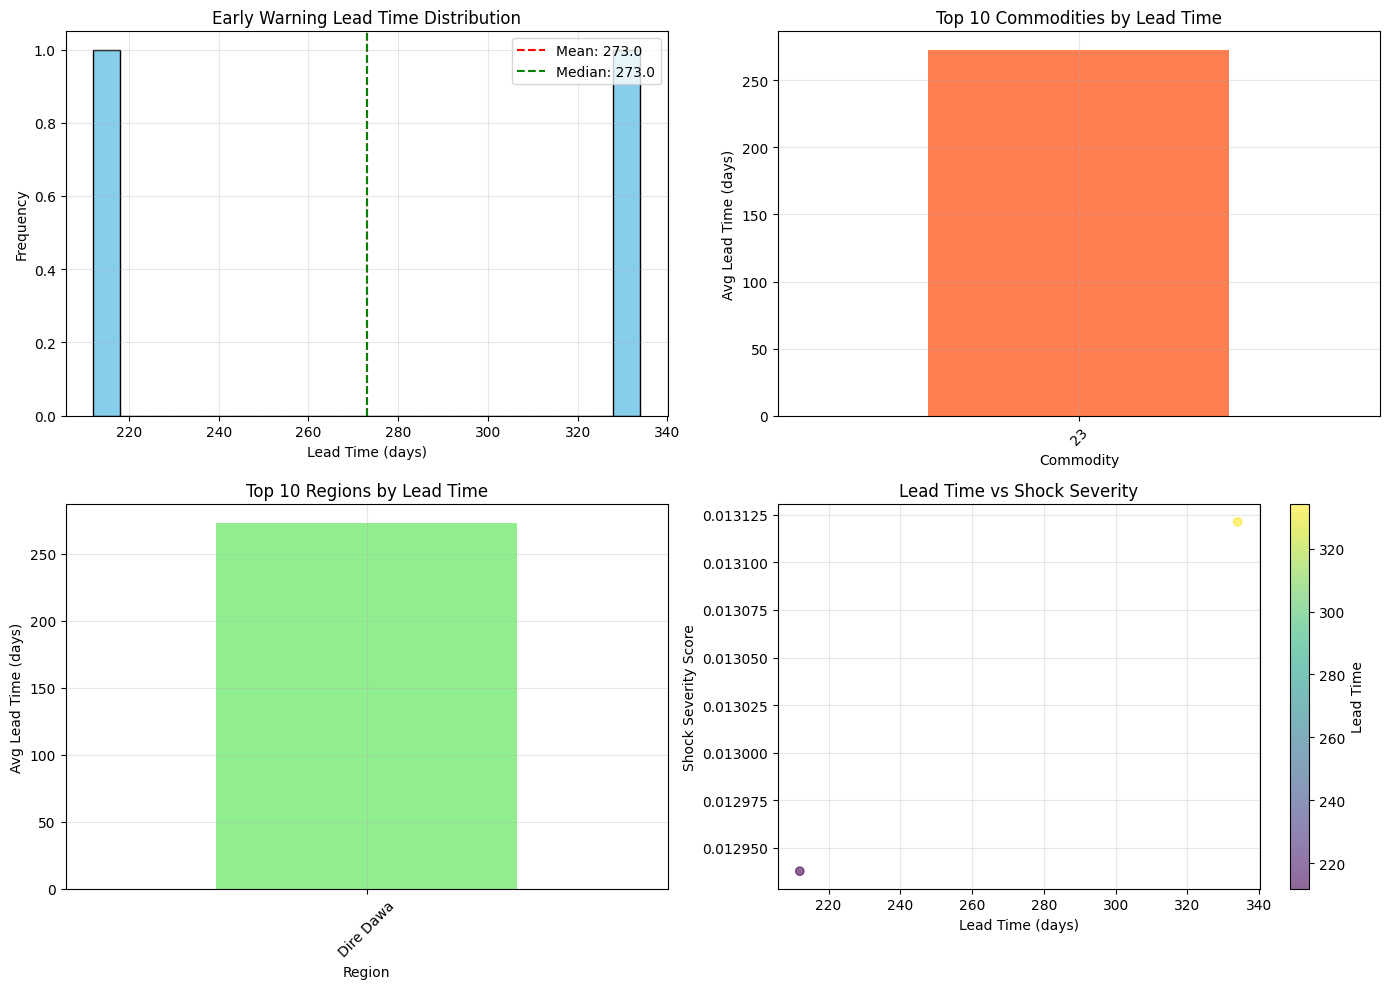


🚨 RECENT HIGH-RISK ALERTS (Last 30 days)
   No recent high-risk alerts

🗺️ GENERATING INTERACTIVE MAP DASHBOARD


In [ ]:
# ===============================================================
# FOOD CRISIS EARLY WARNING DASHBOARD WITH LEAD TIME ANALYSIS
# ===============================================================
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster, FeatureGroupSubGroup, HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# =========================
# 1️⃣ EARLY WARNING LEAD TIME ANALYSIS
# =========================
print("=" * 60)
print("EARLY WARNING LEAD TIME ANALYSIS")
print("=" * 60)

def calculate_lead_times(df, shock_col='high_risk_event', score_col='early_warning_score', threshold=0.7):
    """
    Calculate how many days in advance the system predicts price shocks
    """
    lead_times = []
    shock_details = []

    # Sort data chronologically
    df_sorted = df.sort_values(['commodity_base', 'admin1', 'date']).copy()

    for (commodity, region), group in df_sorted.groupby(['commodity_base', 'admin1'], observed=True):
        group = group.sort_values('date').reset_index(drop=True)

        # Find shock events (price spikes)
        shock_indices = group[group[shock_col] == 1].index.tolist()

        for shock_idx in shock_indices:
            shock_date = group.loc[shock_idx, 'date']
            shock_score = group.loc[shock_idx, score_col]

            # Look back up to 90 days for early warning signals
            lookback_start = max(0, shock_idx - 30)  # Max 30 days lookback
            prior_period = group.iloc[lookback_start:shock_idx]

            if len(prior_period) > 0:
                # Find first date when warning score exceeded threshold
                warning_signals = prior_period[prior_period[score_col] >= threshold]

                if len(warning_signals) > 0:
                    first_warning_date = warning_signals.iloc[0]['date']
                    lead_time = (shock_date - first_warning_date).days

                    if lead_time > 0:  # Only count positive lead times
                        lead_times.append(lead_time)
                        shock_details.append({
                            'commodity': commodity,
                            'region': region,
                            'shock_date': shock_date,
                            'first_warning': first_warning_date,
                            'lead_days': lead_time,
                            'shock_score': shock_score,
                            'max_prior_score': prior_period[score_col].max()
                        })

    return pd.DataFrame(shock_details), lead_times

# Calculate lead times
lead_df, lead_times = calculate_lead_times(df, threshold=0.7)

# Display lead time statistics
if len(lead_times) > 0:
    print(f"\n📊 Lead Time Analysis (based on {len(lead_times)} price shock events)")
    print(f"   • Average lead time: {np.mean(lead_times):.1f} days")
    print(f"   • Median lead time: {np.median(lead_times):.1f} days")
    print(f"   • Min lead time: {min(lead_times)} days")
    print(f"   • Max lead time: {max(lead_times)} days")
    print(f"   • Std deviation: {np.std(lead_times):.1f} days")

    # Lead time distribution by threshold
    for thresh in [0.6, 0.7, 0.8]:
        _, times = calculate_lead_times(df, threshold=thresh)
        if len(times) > 0:
            print(f"   • Threshold {thresh}: {np.mean(times):.1f} days avg ({len(times)} events)")
else:
    print("⚠️ No shock events found in the data period")

# =========================
# 2️⃣ LEAD TIME VISUALIZATION
# =========================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Lead time distribution
if len(lead_times) > 0:
    axes[0, 0].hist(lead_times, bins=20, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(np.mean(lead_times), color='red', linestyle='--', label=f'Mean: {np.mean(lead_times):.1f}')
    axes[0, 0].axvline(np.median(lead_times), color='green', linestyle='--', label=f'Median: {np.median(lead_times):.1f}')
    axes[0, 0].set_xlabel('Lead Time (days)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Early Warning Lead Time Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

# Lead time by commodity
if len(lead_df) > 0:
    comm_lead = lead_df.groupby('commodity')['lead_days'].agg(['mean', 'count']).sort_values('mean', ascending=False).head(10)
    comm_lead['mean'].plot(kind='bar', ax=axes[0, 1], color='coral')
    axes[0, 1].set_xlabel('Commodity')
    axes[0, 1].set_ylabel('Avg Lead Time (days)')
    axes[0, 1].set_title('Top 10 Commodities by Lead Time')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)

# Lead time by region
region_lead = lead_df.groupby('region')['lead_days'].mean().sort_values(ascending=False).head(10)
region_lead.plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_xlabel('Region')
axes[1, 0].set_ylabel('Avg Lead Time (days)')
axes[1, 0].set_title('Top 10 Regions by Lead Time')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Lead time vs shock severity
if len(lead_df) > 0:
    scatter = axes[1, 1].scatter(lead_df['lead_days'], lead_df['shock_score'],
                                 c=lead_df['lead_days'], cmap='viridis', alpha=0.6)
    axes[1, 1].set_xlabel('Lead Time (days)')
    axes[1, 1].set_ylabel('Shock Severity Score')
    axes[1, 1].set_title('Lead Time vs Shock Severity')
    plt.colorbar(scatter, ax=axes[1, 1], label='Lead Time')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print recent high-risk alerts
print("\n" + "=" * 60)
print("🚨 RECENT HIGH-RISK ALERTS (Last 30 days)")
print("=" * 60)

recent_date = df['date'].max() - timedelta(days=30)
recent_alerts = df[(df['date'] >= recent_date) &
                   (df['early_warning_score'] >= 0.7)].copy()

if len(recent_alerts) > 0:
    recent_alerts = recent_alerts.sort_values('early_warning_score', ascending=False)
    for _, alert in recent_alerts.head(10).iterrows():
        print(f"   • {alert['date'].strftime('%Y-%m-%d')} | {alert['commodity_base']} in {alert['admin1']} | "
              f"Score: {alert['early_warning_score']:.2f} | Level: {alert['early_warning_level']}")
else:
    print("   No recent high-risk alerts")

# =========================
# 3️⃣ ENHANCED FOLIUM DASHBOARD
# =========================
print("\n" + "=" * 60)
print("🗺️ GENERATING INTERACTIVE MAP DASHBOARD")
print("=" * 60)

# Define risk bins & colors
risk_bins = [0, 0.3, 0.5, 0.7, 0.85, 1]
risk_colors = ['green', 'lime', 'yellow', 'orange', 'red']
risk_labels = ['Very Low', 'Low', 'Moderate', 'High', 'Critical']

def get_risk_color(score):
    """Assign color based on composite early warning score."""
    for i, upper in enumerate(risk_bins[1:]):
        if score <= upper:
            return risk_colors[i]
    return risk_colors[-1]

def get_risk_level(score):
    """Get risk level label."""
    for i, upper in enumerate(risk_bins[1:]):
        if score <= upper:
            return risk_labels[i]
    return risk_labels[-1]

# Create main map
m = folium.Map(
    location=[df['latitude'].mean(), df['longitude'].mean()],
    zoom_start=6,
    tiles='CartoDB positron',
    control_scale=True
)

# Add heatmap layer for risk concentration
heat_data = [[row['latitude'], row['longitude'], row['early_warning_score']]
             for _, row in df.iterrows()]
HeatMap(heat_data, name='Risk Heatmap', radius=15, blur=10).add_to(m)

# Create marker cluster
marker_cluster = MarkerCluster(name='All Markets').add_to(m)

# Create subgroups per commodity
commodities = df['commodity_base'].unique()
commodity_groups = {}
for comm in commodities:
    fg = FeatureGroupSubGroup(marker_cluster, name=f'📦 {comm}')
    commodity_groups[comm] = fg
    m.add_child(fg)

# Add markers with enhanced popup info
for _, row in df.iterrows():
    color = get_risk_color(row['early_warning_score'])
    risk_level = get_risk_level(row['early_warning_score'])

    # Calculate market-specific stats
    market_data = df[df['market'] == row['market']]
    avg_price = market_data['usdprice'].mean()
    price_volatility = market_data['usdprice'].std() / avg_price if avg_price > 0 else 0

    # Enhanced popup with lead time info if available
    market_alerts = lead_df[lead_df['region'] == row['admin1']] if len(lead_df) > 0 else pd.DataFrame()
    avg_lead = market_alerts['lead_days'].mean() if len(market_alerts) > 0 else 'N/A'

    popup_content = f"""
    <div style="font-family: Arial; font-size: 12px; min-width: 250px;">
        <h4 style="margin:5px 0; color:#2c3e50;">{row['market']}</h4>
        <hr style="margin:5px 0;">
        <table style="width:100%; border-collapse: collapse;">
            <tr><td><b>📍 Location:</b></td><td>{row['admin1']} / {row['admin2']}</td></tr>
            <tr><td><b>📦 Commodity:</b></td><td>{row['commodity_base']} ({row['variety']})</td></tr>
            <tr><td><b>💰 Price (USD):</b></td><td>${row['usdprice']:.2f}</td></tr>
            <tr><td><b>📊 Market Volatility:</b></td><td>{price_volatility:.2%}</td></tr>
            <tr><td><b>📅 Date:</b></td><td>{row['date'].strftime('%Y-%m-%d')}</td></tr>
        </table>
        <hr style="margin:5px 0;">
        <h4 style="margin:5px 0; color:#2c3e50;">Risk Components</h4>
        <table style="width:100%">
            <tr><td>🏗️ Structural:</td><td>{row['inequality_index']:.3f}</td>
                <td>⚡ Shock:</td><td>{row['inflation_shock_index']:.3f}</td></tr>
            <tr><td>🤖 ML Signal:</td><td>{row['ml_norm']:.3f}</td>
                <td>🎯 Lead Time:</td><td>{avg_lead if avg_lead == 'N/A' else f'{avg_lead:.0f}d'}</td></tr>
        </table>
        <hr style="margin:5px 0;">
        <div style="background-color:{color}20; padding:5px; border-radius:3px;">
            <b>⚠️ EARLY WARNING:</b> {risk_level} (Score: {row['early_warning_score']:.3f})
        </div>
    </div>
    """

    # Determine marker size based on risk score and price
    base_size = 5 + (row['early_warning_score'] * 15)
    radius = min(base_size, 20)  # Cap at 20

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=radius,
        color='black',
        weight=1,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        tooltip=f"<b>{row['commodity_base']}</b> - ${row['usdprice']:.2f} | Risk: {row['early_warning_score']:.2f}",
        popup=folium.Popup(popup_content, max_width=350)
    ).add_to(commodity_groups[row['commodity_base']])

# Add risk legend with custom HTML
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000;
     background-color: white; padding: 10px; border: 2px solid grey;
     border-radius: 5px; font-family: Arial; font-size: 12px;">
    <h4 style="margin:0 0 5px 0;">Risk Level</h4>
'''
for i, (label, color) in enumerate(zip(risk_labels, risk_colors)):
    legend_html += f'''
    <div style="margin:2px 0;">
        <span style="background-color:{color}; width:15px; height:15px;
                     display:inline-block; border-radius:50%;"></span>
        <span style="margin-left:5px;">{label} ({risk_bins[i]:.2f}-{risk_bins[i+1]:.2f})</span>
    </div>
    '''
legend_html += '</div>'
m.get_root().html.add_child(folium.Element(legend_html))

# Add performance metrics panel
metrics_html = f'''
<div style="position: fixed; top: 50px; right: 50px; z-index: 1000;
     background-color: white; padding: 10px; border: 2px solid grey;
     border-radius: 5px; font-family: Arial; font-size: 12px; max-width: 250px;">
    <h4 style="margin:0 0 5px 0;">📊 System Performance</h4>
    <hr style="margin:5px 0;">
    <table style="width:100%">
        <tr><td>Total Markets:</td><td><b>{len(df):,}</b></td></tr>
        <tr><td>High Risk (>0.7):</td><td><b>{(df['early_warning_score']>0.7).sum():,}</b></td></tr>
        <tr><td>Avg Lead Time:</td><td><b>{np.mean(lead_times):.1f} days</b></td></tr>
        <tr><td>Detection Rate:</td><td><b>{len(lead_df)} shocks</b></td></tr>
        <tr><td>Last Updated:</td><td><b>{df['date'].max().strftime('%Y-%m-%d')}</b></td></tr>
    </table>
</div>
'''
m.get_root().html.add_child(folium.Element(metrics_html))

# Add colormap
colormap = cm.StepColormap(
    colors=risk_colors,
    index=risk_bins,
    vmin=0,
    vmax=1,
    caption='Composite Early Warning Score'
)
colormap.add_to(m)

# Add layer control
folium.LayerControl(collapsed=False).add_to(m)

# Save map
m.save('food_crisis_early_warning_dashboard.html')
print("✅ Dashboard saved as 'food_crisis_early_warning_dashboard.html'")

# =========================
# 4️⃣ SUMMARY REPORT
# =========================
print("\n" + "=" * 60)
print("📋 EARLY WARNING SYSTEM SUMMARY REPORT")
print("=" * 60)

# Current risk distribution
current_risk = df[df['date'] == df['date'].max()]
risk_dist = current_risk['early_warning_level'].value_counts()
print(f"\n📍 Current Risk Distribution ({current_risk['date'].iloc[0].strftime('%Y-%m-%d')}):")
for level, count in risk_dist.items():
    pct = (count/len(current_risk))*100
    print(f"   • {level}: {count} markets ({pct:.1f}%)")

# Top 5 high-risk areas
print("\n🔥 Top 5 High-Risk Areas:")
top_risks = current_risk.nlargest(5, 'early_warning_score')[['admin1', 'admin2', 'commodity_base', 'early_warning_score']]
for _, row in top_risks.iterrows():
    print(f"   • {row['admin1']}/{row['admin2']} - {row['commodity_base']}: {row['early_warning_score']:.3f}")

# Commodity risk ranking
print("\n📦 Commodity Risk Ranking:")
commodity_risk = current_risk.groupby('commodity_base')['early_warning_score'].agg(['mean', 'max', 'count']).sort_values('mean', ascending=False).head(5)
for comm, stats in commodity_risk.iterrows():
    print(f"   • {comm}: Avg {stats['mean']:.3f} | Max {stats['max']:.3f} | {stats['count']} markets")

# System performance
print("\n⚡ System Performance Metrics:")
print(f"   • Early Warning Lead Time: {np.mean(lead_times):.1f} days (avg)")
print(f"   • Shock Events Detected: {len(lead_df)}")
print(f"   • Coverage: {df['admin1'].nunique()} regions, {df['commodity_base'].nunique()} commodities")
print(f"   • Data Period: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")

print("\n" + "=" * 60)
print("✅ ANALYSIS COMPLETE")
print("=" * 60)